## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [6]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [1]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [8]:
# Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
# The checkpoints are:

# * __21__ - minimal score to submit the homework, 30% of points

# * __25__ - good score, 70% of points

# * __27__ - excellent score, 100% of points

### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface: 
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [56]:
# old deprecated code
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [57]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [107]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [59]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [60]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [108]:
SRC.build_vocab(train_data, min_freq = 3)

TRG.build_vocab(train_data, min_freq = 3)

In [111]:
dataset.fields

{'trg': <torchtext.data.field.Field at 0x7f4b003dc0a0>,
 'src': <torchtext.data.field.Field at 0x7f4b003dc4c0>}

In [8]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9285
Unique tokens in target (en) vocabulary: 6708


Here are tokens from original (RU) corpus:

In [62]:
SRC.vocab.itos[::1000]

['<unk>',
 'радиусе',
 'транспорта',
 'купаться',
 'cottages',
 '69',
 'mirage',
 'форум',
 'дружбы',
 'типичной']

And from target (EN) corpus:

In [63]:
TRG.vocab.itos[::1000]

['<unk>', 'palm', 'freedom', 'chi', 'nairobi', 'schwedenplatz', 'malindi']

And here is example from train dataset:

In [64]:
print(vars(train_data.examples[9]))

{'trg': ['free', 'private', 'parking', 'is', 'available', 'on', 'site', '.'], 'src': ['на', 'прилегающей', 'территории', 'обустроена', 'бесплатная', 'частная', 'парковка', '.']}


Let's check the length distributions:

Length distribution in Train data


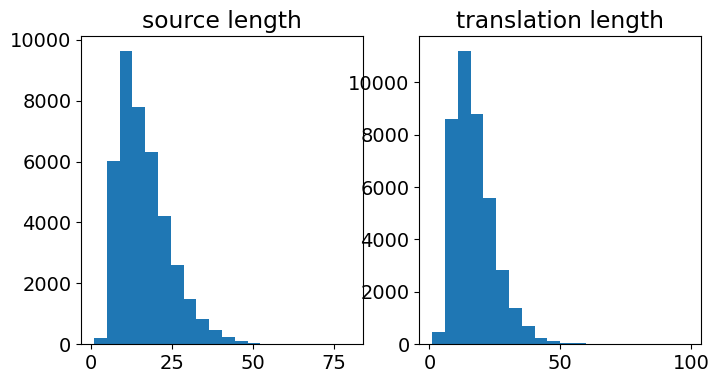

In [65]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


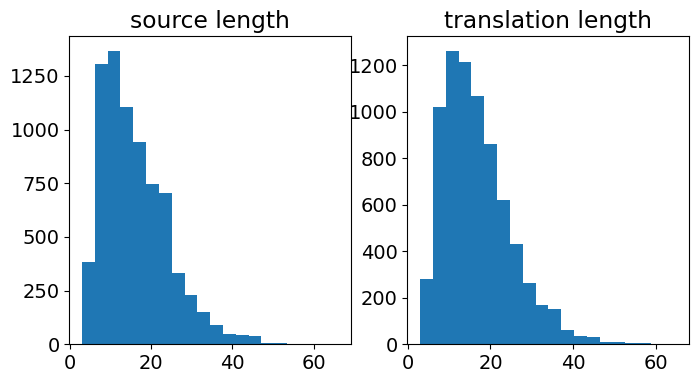

In [66]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [68]:
device

device(type='cuda')

In [69]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [70]:
train_data[0]

In [71]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 32]
	[.trg]:[torch.cuda.LongTensor of size 37x32 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 33x32 (GPU 0)]
torch.Size([33, 32]) torch.Size([37, 32])


In [14]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq


In [23]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device

model = Seq2Seq(enc, dec, device).to(device)

In [24]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9261, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6686, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6686, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,868,766 trainable parameters


In [26]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [39]:
SRC.vocab

In [58]:
 for i, batch in enumerate(train_iterator):
        src = batch.src
        trg = batch.trg
        print(src.shape, trg.shape)
        

torch.Size([44, 32]) torch.Size([60, 32])
torch.Size([36, 32]) torch.Size([34, 32])
torch.Size([39, 32]) torch.Size([30, 32])
torch.Size([43, 32]) torch.Size([42, 32])
torch.Size([36, 32]) torch.Size([37, 32])
torch.Size([45, 32]) torch.Size([44, 32])
torch.Size([36, 32]) torch.Size([34, 32])
torch.Size([43, 32]) torch.Size([46, 32])
torch.Size([45, 32]) torch.Size([42, 32])
torch.Size([40, 32]) torch.Size([36, 32])
torch.Size([56, 32]) torch.Size([52, 32])
torch.Size([35, 32]) torch.Size([36, 32])
torch.Size([35, 32]) torch.Size([33, 32])
torch.Size([43, 32]) torch.Size([41, 32])
torch.Size([35, 32]) torch.Size([45, 32])
torch.Size([44, 32]) torch.Size([39, 32])
torch.Size([37, 32]) torch.Size([40, 32])
torch.Size([37, 32]) torch.Size([35, 32])
torch.Size([39, 32]) torch.Size([42, 32])
torch.Size([41, 32]) torch.Size([44, 32])
torch.Size([32, 32]) torch.Size([38, 32])
torch.Size([36, 32]) torch.Size([37, 32])
torch.Size([39, 32]) torch.Size([42, 32])
torch.Size([51, 32]) torch.Size([4

torch.Size([43, 32]) torch.Size([57, 32])
torch.Size([36, 32]) torch.Size([39, 32])
torch.Size([28, 32]) torch.Size([36, 32])
torch.Size([35, 32]) torch.Size([37, 32])
torch.Size([37, 32]) torch.Size([37, 32])
torch.Size([39, 32]) torch.Size([40, 32])
torch.Size([39, 32]) torch.Size([41, 32])
torch.Size([42, 32]) torch.Size([54, 32])
torch.Size([44, 32]) torch.Size([41, 32])
torch.Size([35, 32]) torch.Size([35, 32])
torch.Size([41, 32]) torch.Size([38, 32])
torch.Size([46, 32]) torch.Size([43, 32])
torch.Size([38, 32]) torch.Size([39, 32])
torch.Size([37, 32]) torch.Size([41, 32])
torch.Size([38, 32]) torch.Size([37, 32])
torch.Size([45, 32]) torch.Size([50, 32])
torch.Size([33, 32]) torch.Size([36, 32])
torch.Size([38, 32]) torch.Size([30, 32])
torch.Size([39, 32]) torch.Size([36, 32])
torch.Size([48, 32]) torch.Size([43, 32])
torch.Size([43, 32]) torch.Size([51, 32])
torch.Size([45, 32]) torch.Size([50, 32])
torch.Size([41, 32]) torch.Size([39, 32])
torch.Size([39, 32]) torch.Size([3

torch.Size([39, 32]) torch.Size([39, 32])
torch.Size([51, 32]) torch.Size([43, 32])
torch.Size([34, 32]) torch.Size([33, 32])
torch.Size([43, 32]) torch.Size([42, 32])
torch.Size([45, 32]) torch.Size([40, 32])
torch.Size([40, 32]) torch.Size([35, 32])
torch.Size([43, 32]) torch.Size([43, 32])
torch.Size([31, 32]) torch.Size([30, 32])
torch.Size([39, 32]) torch.Size([39, 32])
torch.Size([31, 32]) torch.Size([31, 32])
torch.Size([33, 32]) torch.Size([33, 32])
torch.Size([65, 32]) torch.Size([48, 32])
torch.Size([30, 32]) torch.Size([32, 32])
torch.Size([31, 32]) torch.Size([28, 32])
torch.Size([32, 32]) torch.Size([29, 32])
torch.Size([39, 32]) torch.Size([31, 32])
torch.Size([45, 32]) torch.Size([45, 32])
torch.Size([37, 32]) torch.Size([37, 32])
torch.Size([49, 32]) torch.Size([47, 32])
torch.Size([33, 32]) torch.Size([45, 32])
torch.Size([41, 32]) torch.Size([41, 32])
torch.Size([47, 32]) torch.Size([46, 32])
torch.Size([43, 32]) torch.Size([37, 32])
torch.Size([46, 32]) torch.Size([5

In [23]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [24]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

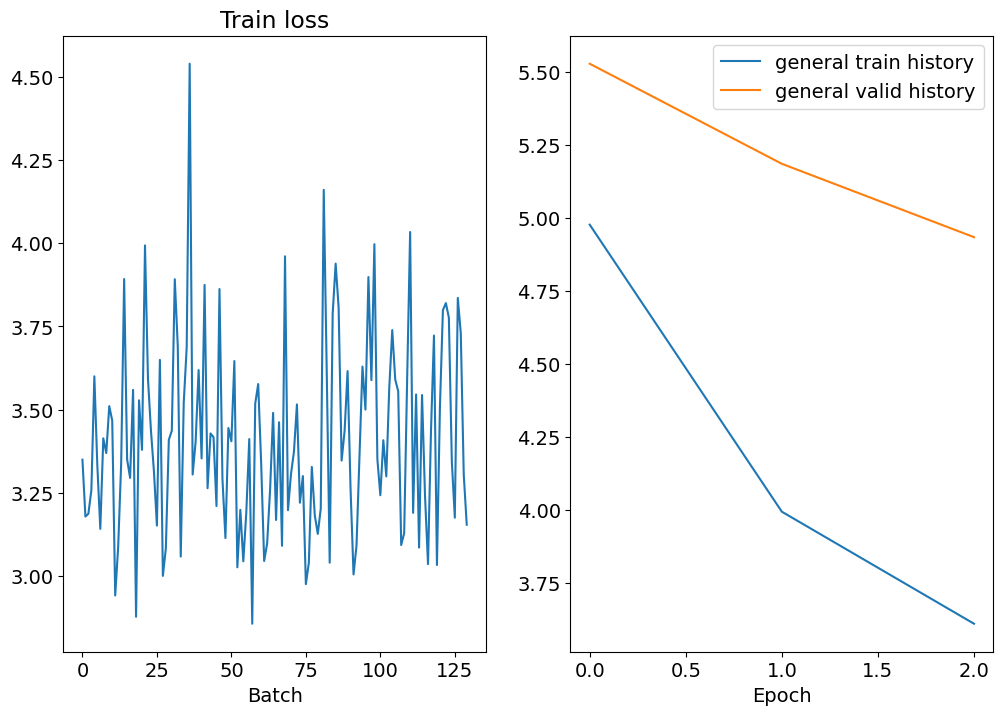

KeyboardInterrupt: 

In [27]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [30]:
# del utils

In [81]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [69]:
batch = next(iter(test_iterator))

In [35]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24 - hour front desk at the property .
Generated: convention showing vinci vinci vinohrady vinohrady vinohrady reina vinohrady reina vinohrady reina reina reina reina

Original: free parking is available at the property .
Generated: showing showing vinci vinci vinohrady vinohrady reina vinohrady reina vinohrady reina reina reina reina reina



In [36]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [64]:
import tqdm

In [43]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:02, 25.09it/s]


In [44]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.294459784522099

## Approaches to improve perfomance

## Self attention mechanism

In [348]:
import attention_network
Encoder = attention_network.Encoder
DecoderWithAttention = attention_network.DecoderWithAttention
Seq2SeqWithAttention = attention_network.Seq2SeqWithAttention

In [349]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = DecoderWithAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device

attention_model = Seq2SeqWithAttention(enc, dec, device).to(device)

In [350]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
attention_model.apply(init_weights)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(9267, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderWithAttention(
    (embedding): Embedding(6690, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention(
      (linear_input): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
    )
    (out): Linear(in_features=512, out_features=6690, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in attention_model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(attention_model):,} trainable parameters')

The model has 15,675,195 trainable parameters


In [36]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(attention_model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [37]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(attention_model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(attention_model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(attention_model.state_dict(), 'tut1-attention_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

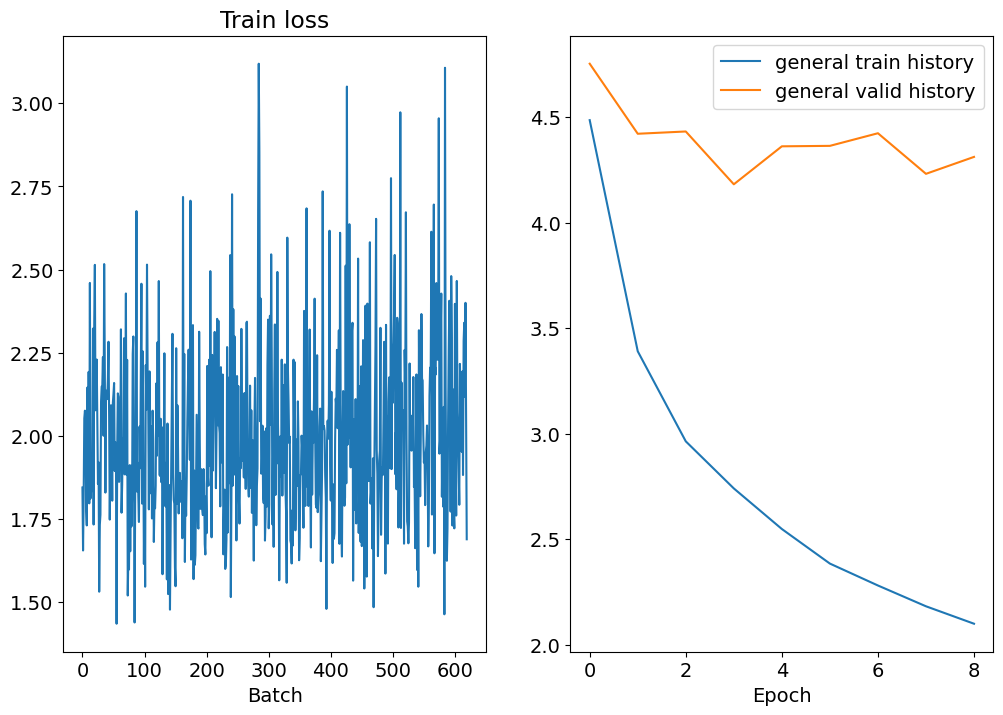

Epoch: 10 | Time: 2m 9s
	Train Loss: 1.996 | Train PPL:   7.362
	 Val. Loss: 4.296 |  Val. PPL:  73.384


In [38]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(attention_model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(attention_model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(attention_model.state_dict(), 'tut1-attention_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [49]:
original_text = []
generated_text = []
attention_model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = attention_model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

118it [00:03, 37.41it/s]


In [50]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

31.131895988218865

### Seq2Seq model with attention significantly outperformed baseline model 
### (BLEU score 31.13 and 14.29 accordingly)
### By attending to different parts of the source sequance, the attention model could better understand and translate complex sentence

## Transfomer

In [192]:
from transformers import AutoTokenizer

checkpoint = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [193]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [78]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, T5ForConditionalGeneration, Seq2SeqTrainer, T5Config

config = T5Config(vocab_size_or_config_json_file=len(SRC.vocab))
model = T5ForConditionalGeneration.from_pretrained('t5-small', config).to(device)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [22]:
source_lang = "ru"
target_lang = "en"
prefix = "translate Russain to English: "


def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [23]:
tokenizer_W = tokenizer
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [25]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [26]:
SRC.build_vocab(train_data, min_freq = 3)

TRG.build_vocab(train_data, min_freq = 3)

In [27]:
import numpy as np
import tqdm


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [54]:
training_args = Seq2SeqTrainingArguments(
    output_dir="checkpoint",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

# trainer = Seq2SeqTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_iterator,
#     eval_dataset=valid_iterator,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )

# trainer.train()

In [29]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 1

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [30]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [52]:
for x in train_iterator:
    print(x)
    break


[torchtext.data.batch.Batch of size 1]
	[.trg]:[torch.cuda.LongTensor of size 11x1 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 35x1 (GPU 0)]


In [48]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        print(src.shape, trg.shape)

        output = model(input_ids=src, decoder_input_ids=src)
        output = output[0]
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        print(src.shape, output.shape)
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [38]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [49]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(attention_model.state_dict(), 'tut1-attention_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

torch.Size([35, 1]) torch.Size([12, 1])
torch.Size([35, 1]) torch.Size([35, 1, 32128])


ValueError: Expected input batch_size (34) to match target batch_size (11).

In [182]:
import tqdm

from nltk.translate.bleu_score import corpus_bleu

In [82]:
original_text = []
generated_text = []
transformer.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = transformer(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

235it [00:17, 13.72it/s]


In [83]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

17.354409314536845

### BLUE score is 17.35, which is not bad for a transformer model which archirecture parameters were barely tuned. 
### Also I tried to increase hidden dim to 512 and num of layers to 4 bit got score of 4.21. 

### Seems like this transformer implementation is sensetive to num of model weights

## Pre-trained Bert

### Warning: this experiment was unsuccessful, no need to dive deep for details

In [90]:
from datasets import load_dataset

books = load_dataset("opus_books", "en-fr")

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

In [198]:
from transformers import AutoTokenizer

checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [199]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint).to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 3.81 GiB total capacity; 2.95 GiB already allocated; 640.00 KiB free; 3.01 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [171]:
source_lang = "en"
target_lang = "ru"
prefix = "translate English to Russian: "


def preprocess_function(example):
#     inputs = [prefix + example[source_lang] for example in examples["translation"]]
#     targets = [example[target_lang] for example in examples["translation"]]
    inputs = prefix + " ".join(example["translation"][source_lang])
    targets = " ".join(example["translation"][target_lang])
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [176]:
train_custom_books = []
for i, obj in enumerate(train_data):
    train_custom_books.append({
        "id": i,
        "translation": {"en": obj.trg,
            "ru": obj.src
        }
    }
    )


In [177]:
valid_custom_books = []
for i, obj in enumerate(valid_data):
    valid_custom_books.append({
        "id": i,
        "translation": {"en": obj.trg,
            "ru": obj.src
        }
    }
    )

In [178]:
train_tokenized_books = list(map(preprocess_function, train_custom_books))
valid_tokenized_books = list(map(preprocess_function, valid_custom_books))

In [182]:
training_args = Seq2SeqTrainingArguments(
    output_dir="t5_checkpoint",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_books,
    eval_dataset=valid_tokenized_books,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.81 GiB total capacity; 2.95 GiB already allocated; 640.00 KiB free; 3.01 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [106]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [21]:
def make_model(src_vocab, tgt_vocab, N_enc, N_dec, hid_dim=512, d_ff=1024, h=8, dropout=0.1):
        config_encoder = BertConfig(vocab_size=src_vocab,
                                hidden_size=hid_dim,
                                num_hidden_layers=N_enc,
                                num_attention_heads=h,
                                intermediate_size=d_ff,
                                hidden_dropout_prob=dropout,
                                attention_probs_dropout_prob=dropout,
                                max_position_embeddings=17,
                                is_decoder=False)
        config_decoder = BertConfig(vocab_size=tgt_vocab,
                                hidden_size=hid_dim,
                                num_hidden_layers=N_dec,
                                num_attention_heads=h,
                                intermediate_size=d_ff,
                                hidden_dropout_prob=dropout,
                                attention_probs_dropout_prob=dropout,
                                max_position_embeddings=17,
                                is_decoder=True)
        config = EncoderDecoderConfig.from_encoder_decoder_configs(config_encoder, config_decoder)                        
        model = EncoderDecoderModel(config=config)
        return model 

In [22]:
model = make_model(src_vocab=INPUT_DIM, tgt_vocab=OUTPUT_DIM, N_enc=6, N_dec=6, 
                   hid_dim=ENC_EMB_DIM, d_ff=1024, h=8, dropout=0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(3485, 256, padding_idx=0)
      (position_embeddings): Embedding(1, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise

In [23]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [24]:
BATCH_SIZE = 4

def _len_sort_key(x):
    return len(x.src)


train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [79]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    max_step = 1000
    
    for i, batch in enumerate(iterator):
        if i == max_step:
            break
            
        src = batch.src
        trg = batch.trg
        
        print(src.shape, trg.shape)
        
#         trg = torch.cat((trg, torch.zeros(src.shape[0] - trg.shape[0], trg.shape[1]).to(device)), 0).type(torch.LongTensor).to(device) 
        
        optimizer.zero_grad()
        
        output = model(input_ids=src, decoder_input_ids=src, labels=src)
        
#         output = output[0]
        print(output[0].shape)
        output = output.view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        token_diff = trg.shape[0] - output.shape[0]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [80]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg
            trg = torch.cat((trg, torch.zeros(src.shape[0] - trg.shape[0], trg.shape[1]).to(device)), 0).type(torch.LongTensor).to(device) 

            output = model(input_ids=src, decoder_input_ids=src, label=src)

            output = output[0]
            output = output[1:].view(-1, output[0].shape[-1])
            trg = trg[1:].view(-1)

            token_diff = trg.shape[0] - output.shape[0]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [81]:
train_history = []
valid_history = []

N_EPOCHS = 1
CLIP = 1

best_valid_loss = float('inf')

In [82]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

torch.Size([97, 4]) torch.Size([24, 4])
torch.Size([])


AttributeError: 'Seq2SeqLMOutput' object has no attribute 'view'

In [309]:
generated_text

[['.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.'],
 ['.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.'],
 ['.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.'],
 ['.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.'],
 ['.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.'],
 ['.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.'],
 ['.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.'],
 ['.',
  '.',
  '.',

### Just dots... 
### Probably not proper appoach to handle inconsistency between source and target embeddings in Bert Encoder - Decoder setup